# 0.3.0 GeoSeries and folium

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import pprint

import geopandas as gpd 
from shapely.geometry import Point

import folium 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append("../../") 

import utils.paths as path
from utils.paths2 import direcciones

## 0.3.2 Find the area of the Urban Residents neighborhood

In [4]:
neighborhoods = gpd.read_file(path.data_external_dir("neighborhoods.geojson"))

art = pd.read_csv(path.data_raw_dir("public_art.csv"), sep=',')
art['geometry'] = art.apply(lambda x: Point(float(x.Longitude), float(x.Latitude)), axis=1)
art_geo = gpd.GeoDataFrame(art, crs = neighborhoods.crs, geometry = art.geometry)

neighborhood_art = gpd.sjoin(art_geo, neighborhoods, op = "within")

urban_art = neighborhood_art.loc[neighborhood_art.name == "Urban Residents"]
urban_polygon = neighborhoods.loc[neighborhoods.name == "Urban Residents"]

In [5]:
print(urban_polygon.head())

               name                                           geometry
41  Urban Residents  MULTIPOLYGON (((-86.78122 36.16457, -86.78205 ...


In [6]:
# Create a copy of the urban_polygon using EPSG:3857 and print the head
urban_poly_3857 = urban_polygon.to_crs(epsg = 3857)
urban_poly_3857 = urban_poly_3857.reset_index(drop=True)
print(urban_poly_3857.head())

# Print the area of urban_poly_3857 in kilometers squared
area = urban_poly_3857.geometry.area / 10**6
print('The area of the Urban Residents neighborhood is ', area[0], ' km squared')

              name                                           geometry
0  Urban Residents  MULTIPOLYGON (((-9660441.281 4323289.005, -966...
The area of the Urban Residents neighborhood is  1.1289896057983686  km squared


## 0.3.4 The center of the Urban Residents neighborhood

In [7]:
# Create downtown_center from urban_poly_3857
downtown_center = urban_poly_3857.geometry.centroid

# Print the type of downtown_center 
print(type(downtown_center))

<class 'geopandas.geoseries.GeoSeries'>


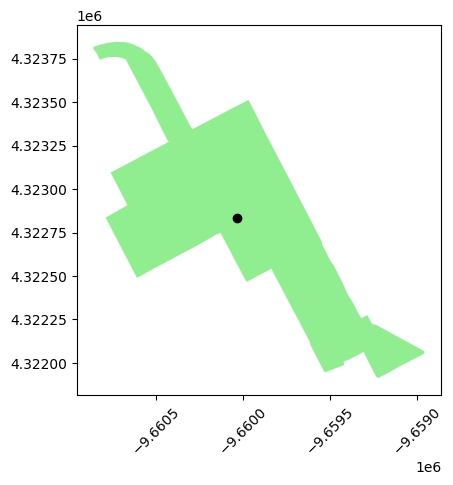

In [8]:
# Plot the urban_poly_3857 as ax and add the center point
ax = urban_poly_3857.plot(color = 'lightgreen')
downtown_center.plot(ax = ax, color = 'black')
plt.xticks(rotation = 45)

# Show the plot
plt.show()

## 0.3.5 Prepare to calculate distances

In [9]:
# Create art_dist_meters using art and the geometry from art
art_dist_meters = gpd.GeoDataFrame(art, geometry = art.geometry, crs = {'init': 'epsg:4326'})
print(art_dist_meters.head(2))

                             Title Last Name First Name  \
0          [Cross Country Runners]     Frost      Miley   
1  [Fourth and Commerce Sculpture]    Walker        Lin   

                            Location  Medium       Type Description  Latitude  \
0     4001 Harding Rd., Nashville TN  Bronze  Sculpture         NaN  36.12856   
1  333 Commerce Street, Nashville TN     NaN  Sculpture         NaN  36.16234   

   Longitude        Mapped Location                    geometry  
0  -86.83660   (36.12856, -86.8366)  POINT (-86.83660 36.12856)  
1  -86.77774  (36.16234, -86.77774)  POINT (-86.77774 36.16234)  


In [10]:
# Set the crs of art_dist_meters to use EPSG:3857
art_dist_meters.geometry = art_dist_meters.geometry.to_crs(epsg = 3857)
print(art_dist_meters.head(2))

                             Title Last Name First Name  \
0          [Cross Country Runners]     Frost      Miley   
1  [Fourth and Commerce Sculpture]    Walker        Lin   

                            Location  Medium       Type Description  Latitude  \
0     4001 Harding Rd., Nashville TN  Bronze  Sculpture         NaN  36.12856   
1  333 Commerce Street, Nashville TN     NaN  Sculpture         NaN  36.16234   

   Longitude        Mapped Location                          geometry  
0  -86.83660   (36.12856, -86.8366)  POINT (-9666606.094 4318325.479)  
1  -86.77774  (36.16234, -86.77774)  POINT (-9660053.829 4322982.159)  


In [11]:
# Add a column to art_meters, center
art_dist_meters['center'] = art_dist_meters.geometry.centroid[0]

## 0.3.6 Art distances from neighborhood center

In [12]:
# Import package for pretty printing
import pprint

# Build a dictionary of titles and distances for Urban Residents art
art_distances = {}
for row in art_dist_meters.iterrows():
    vals = row[1]
    key = vals['Title']
    ctr = vals['center']
    art_distances[key] = vals['geometry'].distance(ctr)

# Pretty print the art_distances
pprint.pprint(art_distances)

{'12th & Porter Mural': 6739.660750717932,
 'A Splash of Color': 6172.770872981447,
 'A Story of Nashville': 7636.51463677786,
 'Aerial Innovations Mural': 12419.099170468773,
 'Airport Sun Project': 18663.062806151505,
 'Andrew Jackson': 7842.076199369634,
 'Angel': 2232.5333759859304,
 'Anticipation': 7889.384527060112,
 'April Baby': 3986.8543698052363,
 'Arial Triangle [from the Gravity Series]': 4564.603032441442,
 'Ariel': 3708.7102999336385,
 'Athena Parthenos': 3905.861528855317,
 'Benedictio': 11932.338083781158,
 'Bicycle Bus-Green Fleet': 8363.108222248331,
 'Blowing Bubbles': 2232.5333759859304,
 'Breaking Bread': 7232.674719142394,
 'Building a Positive Community': 10210.228688176458,
 'Can-Do': 5245.621489645923,
 'Chet Atkins': 7940.21056965972,
 "Children's Chairs For The Seasons": 7636.51463677786,
 'Confederate Memorial': 11932.338083781158,
 'Confederate Private Monument': 3771.4511707518154,
 'Confluence': 8555.812929856733,
 'Cool Fences': 8315.538000682587,
 'Danc

You can see each art title and its distance in meters from the center of the Urban Residents neighborhood.

## 0.3.8 Create a folium location from the urban centroid

In [13]:
# Print the head of the urban_polygon
urban_polygon = urban_polygon.reset_index(drop=True)
urban_polygon['center'] = urban_polygon.geometry.centroid
print(urban_polygon.head()) 

              name                                           geometry  \
0  Urban Residents  MULTIPOLYGON (((-86.78122 36.16457, -86.78205 ...   

                       center  
0  POINT (-86.77756 36.16128)  


In [14]:
# Create urban_center from the urban_polygon center
urban_center = urban_polygon.center[0]
print(urban_center)

POINT (-86.77756457127047 36.161278209287914)


In [15]:
# Create array for folium called urban_location
urban_location = [urban_center.y, urban_center.x]
urban_location

[36.161278209287914, -86.77756457127047]

## 0.3.9 Create a folium map of downtown Nashville

In [16]:
# Construct a folium map with urban_location
downtown_map = folium.Map(location = urban_location, zoom_start = 15)
display(downtown_map)

## 0.3.10 Folium street map of the downtown neighborhood

In [17]:
# Create array for called folium_loc from the urban_polygon center point
point = urban_polygon.center[0]
folium_loc = [point.y, point.x]

In [18]:
# Construct a map from folium_loc: downtown_map
downtown_map = folium.Map(location = folium_loc, zoom_start = 15)
# Draw our neighborhood: Urban Residents
folium.GeoJson(urban_polygon.geometry).add_to(downtown_map)
display(downtown_map)

## 0.3.12 Adding markers for the public art

In [19]:
# Iterate through the urban_art and print each part of tuple returned
for row in urban_art.iterrows():
  print('first part: ', row[0])
  print('second part: ', row[1])

first part:  1
second part:  Title                [Fourth and Commerce Sculpture]
Last Name                                     Walker
First Name                                       Lin
Location           333 Commerce Street, Nashville TN
Medium                                           NaN
Type                                       Sculpture
Description                                      NaN
Latitude                                    36.16234
Longitude                                  -86.77774
Mapped Location                (36.16234, -86.77774)
geometry                  POINT (-86.77774 36.16234)
index_right                                       41
name                                 Urban Residents
Name: 1, dtype: object
first part:  4
second part:  Title                                           A Story of Nashville
Last Name                                                     Ridley
First Name                                                      Greg
Location               

In [20]:
# Create a location and marker with each iteration for the downtown_map
for row in urban_art.iterrows():
    row_values = row[1] 
    location = [row_values['Latitude'], row_values['Longitude']]
    marker = folium.Marker(location = location)
    marker.add_to(downtown_map)

# Display the map
display(downtown_map)

## 0.3.13 Troubleshooting data issues

In [21]:
# Print the urban_art titles
print(urban_art.Title)

1                        [Fourth and Commerce Sculpture]
4                                   A Story of Nashville
21                                           Chet Atkins
22                     Children's Chairs For The Seasons
34                                       Foliated Scroll
39                                          Gone Fishing
40                             Happy Times at The Arcade
54                                     Johnny Cash Mural
55                                 La Storia della Terra
57                                 Les Paul Guitar Mural
59                                         Library Doors
60                               Lightning Wire Fountain
66     Nashville, A History through Maps and Aerial V...
67                                               Oh, Roy
68                                  Orpheus and Eurydice
75                               Piecing It All Together
104                                  The Birth of Apollo
105                            

In [22]:
# Replace Nan and ' values in description
urban_art.Description.fillna('', inplace = True)
urban_art.Description = urban_art.Description.str.replace("'", "`")

#Print the urban_art descriptions again
print(urban_art.Description)

1                                                       
4      Inside the Grand Reading Room, this is a serie...
21     A sculpture of a young Chet Atkins seated on a...
22                     chairs depicting the four seasons
34     a contemporary adaptation of a classical folia...
39     Just having some fun with Trompe L`oeil balconies
40          Trompe L`oeil artwork celebrating The Arcade
54     Classic street art by Thoughts Manifested crew...
55     A 20 foot tower of stone books. There are 26 b...
57                                                      
59     images of local people as well as Tennessee an...
60                                                      
66     Eight scenes showing the development of Nashvi...
67     Minnie Pearl and Roy Acuff seated on a bench i...
68     Relief sculpture above main entrance of Scherm...
75                                                      
104    Two figures topping a fountain, one with a lyr...
105    Statue commemorating Ken

## 0.3.14 A map of downtown art

In [23]:
nashville = folium_loc

# Construct downtown map
downtown_map = folium.Map(location = nashville, zoom_start = 15)
folium.GeoJson(urban_polygon.geometry).add_to(downtown_map)

# Create popups inside the loop you built to create the markers
for row in urban_art.iterrows():
    row_values = row[1] 
    location = [row_values['Latitude'], row_values['Longitude']]
    popup =  (str(row_values['Title']) + ': ' +  str(row_values['Description'])).replace('`', '\'')
    marker = folium.Marker(location = location, popup = popup)
    marker.add_to(downtown_map)

# Display the map.
display(downtown_map)

In [24]:
print('ok_')

ok_
